# NFL Data Tracking Analysis / Classification

This notebook will go over an outline of how to utilize NFL tracking data to classify coverages and WR routes. I am using the framework outlined by this paper:

Dutta et al, 2019, "Unsupervised Methods for Identifying Pass Coverage Among Defensive Backs with NFL Player Tracking Data" https://arxiv.org/abs/1906.11373

The animations and plots of tracking data are from the following Kaggle notebooks:

https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position

https://www.kaggle.com/ar2017/nfl-big-data-bowl-2021-animating-players-movement

The ultimate objective is first to follow the methodology of the paper to classify man vs zone in coverage, then adapt what was done to see if I can build an supervised classification model to identify routes run by the receiver if they were targeted.

## Methods of the Paper

First, they define a set of features from the tracking data that distinguish between "man" and "zone" coverage. They use mixture models to create clusters corresponding to each group, allowing them to provide probabilistic assignments to each coverage type (or cluster). Additionally, they quantify each feature’s influence in distinguishing defensive pass coverage types. First, I will attempt to replicate the features they built, only on week 1 of the tracking data just to test it out.

In [58]:
import pandas as pd
import numpy as np
import seaborn as sns
from ipywidgets import interact, fixed

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import animation
from matplotlib.animation import FFMpegWriter
pd.set_option('max_columns', 100)

import dateutil
from math import radians
from IPython.display import Video

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import os
import warnings
warnings.filterwarnings('ignore')

In [59]:
plays = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
week = pd.read_csv('nfl-big-data-bowl/week1.csv')

In [62]:
week

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,None,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,None,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,None,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,None,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,None,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986017,2018-09-11T05:29:39.900Z,33.68,43.14,1.96,3.79,0.22,281.35,309.70,None,2556277.0,Marqui Christian,41.0,SS,65,away,2018091001,4192,left,NaN
986018,2018-09-11T05:29:39.900Z,36.02,40.21,0.81,1.52,0.09,308.07,234.06,None,2556593.0,Cory Littleton,58.0,ILB,65,away,2018091001,4192,left,NaN
986019,2018-09-11T05:29:39.900Z,33.02,43.81,2.63,4.57,0.27,183.83,314.39,None,2556885.0,Jalen Richard,30.0,RB,65,home,2018091001,4192,left,SCREEN
986020,2018-09-11T05:29:39.900Z,34.13,40.86,0.15,0.72,0.02,6.17,267.87,None,2558183.0,John Johnson,43.0,SS,65,away,2018091001,4192,left,NaN


<img src="time-snap.png" width=640 height=480 />

We will create time periods of when the ball is snapped, split between the three sections similar to the image above from the paper. These sections will be "before snap", "after snap, before throw", and "after throw". I have information on when the ball is snapped and when the pass is thrown, so I will be able to create the variables required.

In [4]:
print(week['event'].unique())
week.columns ## event is 8, frame is 13

['None' 'ball_snap' 'pass_forward' 'pass_arrived' 'pass_outcome_caught'
 'out_of_bounds' 'pass_outcome_incomplete' 'first_contact' 'tackle'
 'man_in_motion' 'play_action' 'qb_sack' 'fumble'
 'fumble_offense_recovered' 'handoff' 'pass_tipped'
 'pass_outcome_interception' 'qb_strip_sack' 'pass_shovel' 'line_set'
 'shift' 'touchdown' 'fumble_defense_recovered' 'pass_outcome_touchdown'
 'run' 'touchback' 'penalty_flag' 'penalty_accepted' 'qb_spike'
 'field_goal_blocked']


Index(['time', 'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'nflId',
       'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId',
       'playId', 'playDirection', 'route'],
      dtype='object')

In [5]:
# Convert dataframe to array to make iteration faster
weekArray = np.array(week)
# Create previous event variable to overwrite and check against when setting new ones
prevEvent = 'ball_snap'

for i, play in enumerate(weekArray):
    # The "event" on the field, i.e. ball snap or between snap or after throw
    event = play[8]
    frameId = play[13]
    # Create before snap category
    # Set equal to "ball_snap" if not available yet, or if it is first frame of motion
    if (prevEvent == 'ball_snap' and event != 'ball_snap') or frameId == 1:
        weekArray[i][8] = 'ball_snap'
        prevEvent = 'ball_snap'
    # Default value for ball_snap in dataset was for the first frame the ball was actually snapped
    elif (event == 'ball_snap'):
        prevEvent = 'between_snap'
    # Set value equal to "between_snap" if it is after snap and before pass thrown
    elif (prevEvent == 'between_snap' and event != 'pass_forward'):
        weekArray[i][8] = 'between_snap'
        prevEvent = 'between_snap'
    # Default value for "pass_forward" in dataset was for the first frame the ball left QB's hand
    elif (event == 'pass_forward'):
        weekArray[i][8] = 'after_throw'
        prevEvent = 'after_throw'
    # Extra cases where the ball has been thrown and is not the first frame of action
    elif (prevEvent == 'after_throw' and frameId != 1):
        weekArray[i][8] = 'after_throw'
        prevEvent = 'after_throw'
        
weekMod = pd.DataFrame(weekArray, columns=week.columns)
week['event'] = weekMod['event']
weekMod = week

In [26]:
week['event'] = ['before_throw' if e=='ball_snap' else e for e in week['event']]
print(week['event'].unique())

['before_throw' 'between_snap' 'after_throw']


## Features generated in the paper

The paper created the following features:

<img src="feat-create.png" width=640 height=480 />
<img src="feat-create2.png" width=640 height=480 />

In [7]:
## var in the x, y, speed
varX = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['x'].agg(['var']).reset_index().rename(columns={"var": "varX"})
varY = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['y'].agg(['var']).reset_index().rename(columns={"var": "varY"})
varS = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['s'].agg(['var']).reset_index().rename(columns={"var": "varS"})

In [9]:
## mean, var distance of nearest opposing player
groupedWeek = weekMod.groupby(['gameId', 'playId', 'frameId'])
playerXY = {}
# get relevant player direction information
for name, group in groupedWeek:
    playerXY[name] = []
    for row in group.iterrows():
        data = [row[1]['nflId'], row[1]['team'], row[1]['x'], row[1]['y'], row[1]['dir']]
        playerXY[name].append(data)

features = list(weekMod.columns)
weekArray = np.array(weekMod)
minOppDist = []
# for each player in each frame
# want to get their distance from nearest opposing player
for player in weekArray:
    ## exclude the actual tracking of the football
    if player[features.index('team')] != 'football':
        ## look in specific game -> play -> frame of play for each player
        opponentPositions = playerXY[(player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')])]
        ## create list to store
        distances = []
        directions = []
        opponents = []
        xs = []
        ys = []
        ## for the player distances
        for oppPos in opponentPositions: 
            if player[features.index('team')] != oppPos[1] and player[features.index('team')] != 'football' and oppPos[1] != 'football':
                dx = (player[features.index('x')] - oppPos[2])**2
                dy = (player[features.index('y')] - oppPos[3])**2
                dist = np.sqrt(dx+dy)
                distances.append(dist)
                directions.append(oppPos[4])
                opponents.append(oppPos[0])
                xs.append(oppPos[2])
                ys.append(oppPos[3])
        minDist = min(distances)
        closestOpponent = opponents[np.argmin(distances)]
        opponentDir = directions[np.argmin(distances)]
        opponentX = xs[np.argmin(distances)]
        opponentY = ys[np.argmin(distances)]
        summary = [player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')], player[features.index('nflId')], minDist, closestOpponent, opponentDir, opponentX, opponentY]
        minOppDist.append(summary)
        
minOppDist = pd.DataFrame(minOppDist, columns=['gameId', 'playId', 'frameId', 'nflId', 'oppMinDist', 'closestOpp(nflId)', 'oppDir', 'oppX', 'oppY'])
weekMod = pd.merge(weekMod, minOppDist, how='left', on=['gameId', 'frameId', 'playId', 'nflId'])
oppVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMinDist'].agg(['var']).reset_index().rename(columns={"var": "oppVar"})
oppMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMinDist'].agg(['mean']).reset_index().rename(columns={"mean": "oppMean"})

In [10]:
## mean, var distance of nearest teammate
features = list(weekMod.columns)
weekArray = np.array(weekMod)
minMateDist = []
for player in weekArray:
    if player[features.index('team')] != 'football':
        matePositions = playerXY[(player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')])]
        distances = []
        mates = []
        xs = []
        ys = []
        for matePos in matePositions: 
            if player[features.index('team')] == matePos[1] and player[features.index('nflId')] != matePos[0] and player[features.index('team')] != 'football' and matePos[1] != 'football':
                dx = (player[features.index('x')] - matePos[2])**2
                dy = (player[features.index('y')] - matePos[3])**2
                dist = np.sqrt(dx+dy)
                distances.append(dist)
                mates.append(matePos[0])
                xs.append(oppPos[2])
                ys.append(oppPos[3])
        minDist = min(distances)
        closestMate = mates[np.argmin(distances)]
        mateX = xs[np.argmin(distances)]
        mateY = ys[np.argmin(distances)]
        summary = [player[features.index('gameId')], player[features.index('playId')], player[features.index('frameId')], player[features.index('nflId')], minDist, closestMate, mateX, mateY]
        minMateDist.append(summary)
        
minMateDist = pd.DataFrame(minMateDist, columns=['gameId', 'playId', 'frameId', 'nflId', 'mateMinDist', 'closestMate(nflId)', 'mateX', 'mateY'])
weekMod = pd.merge(weekMod, minMateDist, how='left', on=['gameId', 'frameId', 'playId', 'nflId'])
mateVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['mateMinDist'].agg(['var']).reset_index().rename(columns={"var": "mateVar"})
mateMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['mateMinDist'].agg(['mean']).reset_index().rename(columns={"mean": "mateMean"})

In [15]:
## create direction difference
diffDir = np.absolute(weekMod['dir'] - weekMod['oppDir'])
weekMod['diffDir'] = diffDir
oppDirVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['diffDir'].agg(['var']).reset_index().rename(columns={"var": "oppDirVar"})
oppDirMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['diffDir'].agg(['mean']).reset_index().rename(columns={"mean": "oppDirMean"})

## create ratio of distances
ratio = weekMod['oppMinDist'] / np.sqrt((weekMod['oppX'] - weekMod['mateX'])**2 + (weekMod['oppY'] - weekMod['mateY'])**2)
weekMod['oppMateDistRatio'] = ratio
oppMateDistRatioMean = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMateDistRatio'].agg(['mean']).reset_index().rename(columns={"mean": "meanOppMateDistRatio"})
oppMateDistRatioVar = weekMod.groupby(['gameId', 'playId', 'event', 'nflId'])['oppMateDistRatio'].agg(['var']).reset_index().rename(columns={"var": "varOppMateDistRatio"})

In [28]:
features = [varX, varY, varS, oppVar, oppMean, mateVar, mateMean, oppDirVar, oppDirMean, oppMateDistRatioMean, oppMateDistRatioVar]
for feature in features:
    weekMod = pd.merge(weekMod, feature, how='left', on=['gameId', 'event', 'playId', 'nflId'])

In [29]:
# Set the train dataset
X = weekMod.loc[weekMod['position'] == 'CB'][weekMod.columns[30:]].dropna()
xTrain = X.drop_duplicates()

# Scale the data
scaler = MinMaxScaler()
scaler.fit(xTrain)
xTrainScaled = scaler.transform(xTrain)

# Set and train the GMM
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(xTrainScaled)

# Make class prediction and probability estimation
pred = gmm.predict(X)
prob = gmm.predict_proba(X)

# Join the class prediction and probability estimation into our main dataframe
X['cluster'] = pred
X['cluster_prob'] = prob[:,0]
weekFin = weekMod.join(X[['cluster', 'cluster_prob']])

In [46]:
weekFin

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,frameId,team,gameId,playId,playDirection,route,oppMinDist,closestOpp(nflId),oppDir,oppX,oppY,mateMinDist,closestMate(nflId),mateX,mateY,diffDir,oppMateDistRatio,varX,varY,varS,oppVar,oppMean,mateVar,mateMean,oppDirVar,oppDirMean,meanOppMateDistRatio,varOppMateDistRatio,cluster,cluster_prob
0,2018-09-07T01:07:14.599Z,91.73,26.67,0.00,0.01,0.02,289.57,240.93,ball_snap,310.0,Matt Ryan,2.0,QB,1,away,2018090600,75,left,NaN,6.100525,2558175.0,38.80,85.63,26.59,3.400235,2559033.0,33.29,43.92,202.13,0.110648,0.000009,0.000062,0.000000,0.000504,6.063867,0.000046,3.393964,50.527362,199.977273,0.109966,1.750028e-07,NaN,NaN
1,2018-09-07T01:07:14.599Z,88.89,36.47,0.01,0.01,0.01,105.63,66.66,ball_snap,79848.0,Malcolm Jenkins,27.0,SS,1,home,2018090600,75,left,NaN,1.916899,2533040.0,193.97,90.78,36.15,5.867759,2552315.0,33.29,43.92,127.31,0.033043,0.000036,0.000189,0.000000,0.000025,1.918109,0.000972,5.882770,2637.883442,193.817273,0.033064,7.312639e-09,NaN,NaN
2,2018-09-07T01:07:14.599Z,91.35,44.16,0.02,0.03,0.01,290.45,16.86,ball_snap,2495454.0,Julio Jones,11.0,WR,1,away,2018090600,75,left,HITCH,7.380474,2555383.0,110.32,84.00,43.49,8.030255,2533040.0,33.29,43.92,93.46,0.145538,0.000096,0.000147,0.000067,0.001877,7.415220,0.000221,8.025493,1942.248702,110.977273,0.146257,9.394571e-07,NaN,NaN
3,2018-09-07T01:07:14.599Z,86.31,22.01,0.09,0.42,0.01,70.12,168.91,ball_snap,2495613.0,Corey Graham,24.0,FS,1,home,2018090600,75,left,NaN,4.983252,2555415.0,151.83,91.29,21.83,3.929377,2552689.0,33.29,43.92,17.08,0.080292,0.003216,0.000187,0.001645,0.002955,4.912147,0.005817,4.013412,463.282687,63.215455,0.079150,7.673017e-07,NaN,NaN
4,2018-09-07T01:07:14.599Z,90.78,36.15,0.00,0.00,0.00,257.61,193.97,ball_snap,2533040.0,Mohamed Sanu,12.0,WR,1,away,2018090600,75,left,HITCH,1.916899,79848.0,66.66,88.89,36.47,8.030255,2495454.0,33.29,43.92,127.31,0.034171,0.000000,0.000016,0.000000,0.000025,1.918109,0.000221,8.025493,2637.883442,193.817273,0.034193,8.384209e-09,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986017,2018-09-11T05:29:39.900Z,33.68,43.14,1.96,3.79,0.22,281.35,309.70,after_throw,2556277.0,Marqui Christian,41.0,SS,65,away,2018091001,4192,left,NaN,0.940479,2556885.0,314.39,33.02,43.81,2.323984,2558183.0,33.29,43.92,4.69,3.225815,0.277126,34.902151,1.649024,2.218413,2.991775,11.420737,5.478244,23325.734304,159.538750,0.512020,4.598862e-01,NaN,NaN
986018,2018-09-11T05:29:39.900Z,36.02,40.21,0.81,1.52,0.09,308.07,234.06,after_throw,2556593.0,Cory Littleton,58.0,ILB,65,away,2018091001,4192,left,NaN,3.967896,2550597.0,315.18,32.43,38.52,1.998650,2558183.0,33.29,43.92,81.12,0.725651,0.625229,2.031241,0.581810,1.129689,1.619296,4.014936,4.537267,10906.439354,117.217250,0.532592,6.819830e-01,NaN,NaN
986019,2018-09-11T05:29:39.900Z,33.02,43.81,2.63,4.57,0.27,183.83,314.39,after_throw,2556885.0,Jalen Richard,30.0,RB,65,home,2018091001,4192,left,SCREEN,0.940479,2556277.0,309.70,33.68,43.14,4.002249,2534241.0,33.29,43.92,4.69,1.078448,9.480825,2.817019,1.892552,10.442946,3.807975,3.161102,4.877536,5236.692195,104.892750,0.894473,3.891088e-01,NaN,NaN
986020,2018-09-11T05:29:39.900Z,34.13,40.86,0.15,0.72,0.02,6.17,267.87,after_throw,2558183.0,John Johnson,43.0,SS,65,away,2018091001,4192,left,NaN,2.892335,2550597.0,315.18,32.43,38.52,1.998650,2556593.0,33.29,43.92,47.31,0.528952,4.825613,3.195425,2.946383,7.387544,4.646112,5.305397,4.275220,9753.260261,117.056000,1.446592,2.560650e+00,NaN,NaN


## Implement Visualization of Tracking Data

This is credited to the Kaggle notebooks mentioned in the beginning.

In [30]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=55,
                          highlight_first_down_line=False,
                          yards_to_go=10,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        #plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
        
    if highlight_first_down_line:
        fl = hl + yards_to_go
        plt.plot([fl, fl], [0, 53.3], color='yellow')
        #plt.text(fl + 2, 50, '<- {}'.format(highlighted_name),
        #         color='yellow')
    return fig, ax

In [31]:
def calculate_dx_dy_arrow(x, y, angle, speed, multiplier):
    if angle <= 90:
        angle = angle
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 90 and angle <= 180:
        angle = angle - 90
        dx = np.sin(radians(angle)) * multiplier * speed
        dy = -np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    if angle > 180 and angle <= 270:
        angle = angle - 180
        dx = -(np.sin(radians(angle)) * multiplier * speed)
        dy = -(np.cos(radians(angle)) * multiplier * speed)
        return dx, dy
    if angle > 270 and angle <= 360:
        angle = 360 - angle
        dx = -np.sin(radians(angle)) * multiplier * speed
        dy = np.cos(radians(angle)) * multiplier * speed
        return dx, dy
    
        
def animate_player_movement(weekData, playId, gameId):
    playData = pd.read_csv('nfl-big-data-bowl/pass-2018.csv')
    
    playHome = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "home"')
    playAway = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "away"')
    playFootball = weekData.query('gameId==' + str(gameId) + ' and playId==' + str(playId) + ' and team == "football"')
    
    playHome['time'] = playHome['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playAway['time'] = playAway['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    playFootball['time'] = playFootball['time'].apply(lambda x: dateutil.parser.parse(x).timestamp()).rank(method='dense')
    
    maxTime = int(playAway['time'].unique().max())
    minTime = int(playAway['time'].unique().min())
    
    yardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardlineNumber'].item()
    yardsToGo = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['yardsToGo'].item()
    absoluteYardlineNumber = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['absoluteYardlineNumber'].item() - 10
    playDir = playHome.sample(1)['playDirection'].item()
    
    if (absoluteYardlineNumber > 50):
        yardlineNumber = 100 - yardlineNumber
    if (absoluteYardlineNumber <= 50):
        yardlineNumber = yardlineNumber
        
    if (playDir == 'left'):
        yardsToGo = -yardsToGo
    else:
        yardsToGo = yardsToGo
    
    fig, ax = create_football_field(highlight_line=True, highlight_line_number=yardlineNumber, highlight_first_down_line=True, yards_to_go=yardsToGo)
    playDesc = playData.query('gameId==' + str(gameId) + ' and playId==' + str(playId))['playDescription'].item()
    plt.title(f'Game # {gameId} Play # {playId} \n {playDesc}')
    
    def update_animation(time):
        patch = []
        
        homeX = playHome.query('time == ' + str(time))['x']
        homeY = playHome.query('time == ' + str(time))['y']
        homeNum = playHome.query('time == ' + str(time))['jerseyNumber']
        homeOrient = playHome.query('time == ' + str(time))['o']
        homeDir = playHome.query('time == ' + str(time))['dir']
        homeSpeed = playHome.query('time == ' + str(time))['s']
        homePosition = playHome.query('time == ' + str(time))['position']
        homeCluster = playHome.query('time == ' + str(time))['cluster']
        homeClusterProb = playHome.query('time == ' + str(time))['cluster_prob']
        patch.extend(plt.plot(homeX, homeY, 'o',c='gold', ms=20, mec='white', zorder=3))
        
        # Home players' jersey number 
        for x, y, num in zip(homeX, homeY, homeNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='black', size='medium'))
            
        # Home players' orientation
        for x, y, orient in zip(homeX, homeY, homeOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='gold', width=0.5, shape='full'))
            
        # Home players' direction
        for x, y, direction, speed in zip(homeX, homeY, homeDir, homeSpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # CB coverage scheme
        for x, y, pos, cluster, prob in zip(homeX, homeY, homePosition, homeCluster, homeClusterProb):
            if pos == 'CB':
                patch.append(plt.text(x, y-6, "P(zone)={}\nP(man)={}".format(prob, 1-prob), va='bottom', ha='center', color='black', size='small',zorder=2, bbox=dict(facecolor='gold', edgecolor='white', pad=2.0)))
        
        awayX = playAway.query('time == ' + str(time))['x']
        awayY = playAway.query('time == ' + str(time))['y']
        awayNum = playAway.query('time == ' + str(time))['jerseyNumber']
        awayOrient = playAway.query('time == ' + str(time))['o']
        awayDir = playAway.query('time == ' + str(time))['dir']
        awaySpeed = playAway.query('time == ' + str(time))['s']
        awayPosition = playAway.query('time == ' + str(time))['position']
        awayCluster = playAway.query('time == ' + str(time))['cluster']
        awayClusterProb = playAway.query('time == ' + str(time))['cluster_prob']
        patch.extend(plt.plot(awayX, awayY, 'o',c='orangered', ms=20, mec='white', zorder=3))
        
        # Away players' jersey number 
        for x, y, num in zip(awayX, awayY, awayNum):
            patch.append(plt.text(x, y, int(num), va='center', ha='center', color='white', size='medium'))
            
        # Away players' orientation
        for x, y, orient in zip(awayX, awayY, awayOrient):
            dx, dy = calculate_dx_dy_arrow(x, y, orient, 1, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='orangered', width=0.5, shape='full'))
        
        # Away players' direction
        for x, y, direction, speed in zip(awayX, awayY, awayDir, awaySpeed):
            dx, dy = calculate_dx_dy_arrow(x, y, direction, speed, 1)
            patch.append(plt.arrow(x, y, dx, dy, color='black', width=0.25, shape='full'))
        
        # CB coverage scheme
        for x, y, pos, cluster, prob in zip(awayX, awayY, awayPosition, awayCluster, awayClusterProb):
            if pos == 'CB':
                patch.append(plt.text(x, y-6, "P(zone)={}\nP(man)={}".format(prob, 1-prob), va='bottom', ha='center', color='white', size='small', zorder=2, bbox=dict(facecolor='orangered', edgecolor='white', pad=2.0)))
        
        # Football location
        footballX = playFootball.query('time == ' + str(time))['x']
        footballY = playFootball.query('time == ' + str(time))['y']
        patch.extend(plt.plot(footballX, footballY, 'o', c='black', ms=10, mec='white', zorder=3, data=playFootball.query('time == ' + str(time))['team']))
        
        
        return patch
    
    ims = [[]]
    for time in np.arange(minTime, maxTime+1):
        patch = update_animation(time)
        ims.append(patch)
        
    anim = animation.ArtistAnimation(fig, ims, repeat=False)
    
    return anim

In [66]:
plays.sample()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,playType,yardlineSide,yardlineNumber,offenseFormation,personnelO,defendersInTheBox,numberOfPassRushers,personnelD,typeDropback,preSnapVisitorScore,preSnapHomeScore,gameClock,absoluteYardlineNumber,penaltyCodes,penaltyJerseyNumbers,passResult,offensePlayResult,playResult,epa,isDefensivePI
324,2018090903,4050,(:55) (Shotgun) B.Gabbert pass incomplete shor...,4,2,10,TEN,play_type_pass,TEN,38,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,4.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,17.0,27.0,00:55:00,72.0,NaN,NaN,I,0,0,-0.33553,False


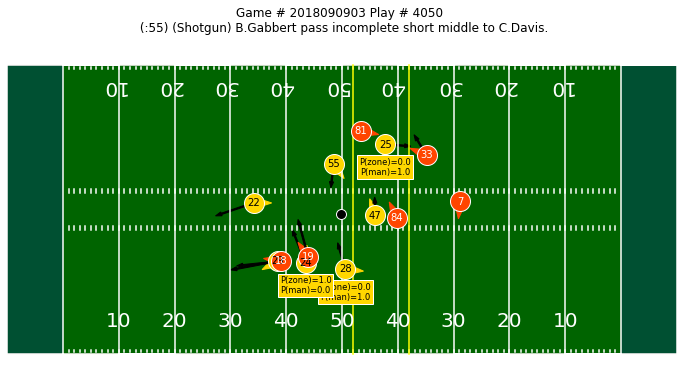

In [67]:
anim = animate_player_movement(weekData=weekFin, playId=4050, gameId=2018090903)
writer = FFMpegWriter(fps=10)
anim.save('anim.mp4', writer=writer)

In [68]:
Video("anim.mp4")

# WR Routes

Perhaps something to focus on is on wide receiver routes and quantifying their effectiveness against man vs zone coverages. Using the framework from above, I have a method to determine whether the corner closest to a receiver is playing in man vs zone (i.e. it doesn't generalize for the entire defense, since there are some hybrid defenses and whatnot).

We have information on the routes the receiver is running..with this framework we can do a similar unsupervised analysis but compare it to the true class labels on the types of routes run? Or can compare to the type of defense being run.

In [65]:
weekFin['route'].unique()

array([nan, 'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN',
       'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL'], dtype=object)